<a href="https://colab.research.google.com/github/julianovale/PO240_Meta_heuristica/blob/main/Projeto_Integrador_Algoritmo_Colonia_de_Formigas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colônia de Formigas

In [12]:
############################################################################

# Created by: Prof. Valdecy Pereira, D.Sc.
# UFF - Universidade Federal Fluminense (Brazil)
# email:  valdecy.pereira@gmail.com
# Course: Metaheuristics
# Lesson: Ant Colony Optimization

# Citation: 
# PEREIRA, V. (2018). Project: Metaheuristic-Ant_Colony_Optimization, File: Python-MH-Ant Colony Optimization.py, GitHub repository: <https://github.com/Valdecy/Metaheuristic-Ant_Colony_Optimization>

############################################################################


import pandas as pd
import random
import numpy  as np
import copy
import os
from matplotlib import pyplot as plt 
import time 

# Function: Tour Distance
def distance_calc(Xdata, city_tour):
    distance = 0
    for k in range(0, len(city_tour[0])-1):
        m = k + 1
        distance = distance + Xdata[city_tour[0][k]-1, city_tour[0][m]-1]            
    return distance

# Function: Euclidean Distance 
def euclidean_distance(x, y):       
    distance = 0
    for j in range(0, len(x)):
        distance = (x[j] - y[j])**2 + distance   
    return distance**(1/2) 

# Function: Build Distance Matrix
def buid_distance_matrix(coordinates):
    Xdata = np.zeros((coordinates.shape[0], coordinates.shape[0]))
    for i in range(0, Xdata.shape[0]):
        for j in range(0, Xdata.shape[1]):
            if (i != j):
                x = coordinates[i,:]
                y = coordinates[j,:]
                Xdata[i,j] = euclidean_distance(x, y)        
    return Xdata

# Function: Tour Plot
def plot_tour_distance_matrix(Xdata, city_tour):
    m = np.copy(Xdata)
    for i in range(0, Xdata.shape[0]):
        for j in range(0, Xdata.shape[1]):
            m[i,j] = (1/2)*(Xdata[0,j]**2 + Xdata[i,0]**2 - Xdata[i,j]**2)    
    w, u = np.linalg.eig(np.matmul(m.T, m))
    s = (np.diag(np.sort(w)[::-1]))**(1/2) 
    coordinates = np.matmul(u, s**(1/2))
    coordinates = coordinates.real[:,0:2]
    xy = np.zeros((len(city_tour[0]), 2))
    for i in range(0, len(city_tour[0])):
        if (i < len(city_tour[0])):
            xy[i, 0] = coordinates[city_tour[0][i]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][i]-1, 1]
        else:
            xy[i, 0] = coordinates[city_tour[0][0]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][0]-1, 1]
    plt.plot(xy[:,0], xy[:,1], marker = 's', alpha = 1, markersize = 7, color = 'black')
    plt.plot(xy[0,0], xy[0,1], marker = 's', alpha = 1, markersize = 7, color = 'red')
    plt.plot(xy[1,0], xy[1,1], marker = 's', alpha = 1, markersize = 7, color = 'orange')
    return

# Function: Initial Attractiveness
def attractiveness(Xdata):
    h = np.zeros((Xdata.shape[0], Xdata.shape[0]))  
    for i in range(0, Xdata.shape[0]):
        for j in range(0, Xdata.shape[1]):
            if (i == j or Xdata[i,j] == 0):
                h[i, j] = 0.000001
            else:
                h[i, j] = 1/Xdata[i,j]   
    return h

# Function: Tour Plot
def plot_tour_coordinates(coordinates, city_tour):
    xy = np.zeros((len(city_tour[0]), 2))
    for i in range(0, len(city_tour[0])):
        if (i < len(city_tour[0])):
            xy[i, 0] = coordinates[city_tour[0][i]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][i]-1, 1]
        else:
            xy[i, 0] = coordinates[city_tour[0][0]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][0]-1, 1]
    plt.plot(xy[:,0], xy[:,1], marker = 's', alpha = 1, markersize = 7, color = 'black')
    plt.plot(xy[0,0], xy[0,1], marker = 's', alpha = 1, markersize = 7, color = 'red')
    plt.plot(xy[1,0], xy[1,1], marker = 's', alpha = 1, markersize = 7, color = 'orange')
    return

# Function: Probability Matrix 
def city_probability(h, thau, city = 0, alpha = 1, beta = 2, city_list = []):
    probability = np.zeros((h.shape[0], 3)) # ['atraction','probability','cumulative_probability']
    for i in range(0, probability.shape[0]):
        if (i+1 not in city_list):
            probability[i, 0] = (thau[i, city]**alpha)*(h[i, city]**beta)
    for i in range(0, probability.shape[0]):
        if (i+1 not in city_list and probability[:,0].sum() != 0):
            probability[i, 1] = probability[i, 0]/probability[:,0].sum()
        if (i == 0):
            probability[i, 2] =  probability[i, 1] 
        else:
            probability[i, 2] = probability[i, 1] + probability[i - 1, 2]     
    if (len(city_list) > 0):
        for i in range(0, len(city_list)):
            probability[city_list[i]-1, 2] = 0.0            
    return probability

# Function: Select Next City
def city_selection(probability_matrix, city_list = []):
    random = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
    city = 0
    for i in range(0, probability_matrix.shape[0]):
        if (random <= probability_matrix[i, 2] and i+1 not in city_list):
          city = i+1
          break     
    return city

# Function: Update Thau
def update_thau(Xdata, thau, city_list = []):
    distance = 0
    for i in range(0, len(city_list)-1):
        j = i + 1
        distance = distance + Xdata[city_list[i]-1,city_list[j]-1] 
    pheromone = 1  
    for i in range(0, len(city_list)-1):
        j = i + 1 
        thau[city_list[i]-1,city_list[j]-1] = thau[city_list[i]-1,city_list[j]-1] + pheromone        
    return thau

# Function: 2_opt
def local_search_2_opt(Xdata, city_tour, recursive_seeding = -1):
    if (recursive_seeding < 0):
        count = -2
    else:
        count = 0
    city_list_new = copy.deepcopy([city_tour[0]])
    city_list_new.append(city_tour[1])
    city_list_old = city_list_new[1]*2
    iteration = 0
    while (count < recursive_seeding):
        best_route = copy.deepcopy(city_list_new)
        seed = copy.deepcopy(city_list_new)        
        for i in range(0, len(city_list_new[0]) - 2):
            for j in range(i+1, len(city_list_new[0]) - 1):
                best_route[0][i:j+1] = list(reversed(best_route[0][i:j+1]))           
                best_route[0][-1]  = best_route[0][0]              
                best_route[1] = distance_calc(Xdata, best_route)                     
                if (city_list_new[1] > best_route[1]):
                    city_list_new = copy.deepcopy(best_route)         
                best_route = copy.deepcopy(seed)
        count = count + 1
        iteration = iteration + 1  
        if (city_list_old > city_list_new[1] and recursive_seeding < 0):
             city_list_old = city_list_new[1]
             count = -2
             recursive_seeding = -1
        elif(city_list_new[1] >= city_list_old and recursive_seeding < 0):
            count = -1
            recursive_seeding = -2
    return city_list_new[0], city_list_new[1]

# Function: Ants City List
def ants_path(Xdata, h, thau, alpha, beta, full_list, ants):
    distance           = np.sum(Xdata.sum())
    best_city_list     = []
    best_path_distance = []
    for ant in range(0, ants):
        city_list = []
        initial = random.randrange(1, Xdata.shape[0])
        city_list.append(initial)           
        for i in range(0, Xdata.shape[0] - 1):
            probability = city_probability(h, thau, city = i, alpha = alpha, beta = beta, city_list = city_list)
            path_point  = city_selection(probability, city_list = city_list)
            if (path_point == 0):
                path_point = [value for value in full_list if value not in city_list][0]
            city_list.append(path_point)
        city_list.append(city_list[0])
        path_distance = 0
        for i in range(0, len(city_list)-1):
            j = i + 1
            path_distance = path_distance + Xdata[city_list[i]-1,city_list[j]-1] 
        if (distance > path_distance):
            best_city_list     = copy.deepcopy(city_list)
            best_path_distance = path_distance
            distance           = path_distance
    best_route = copy.deepcopy([best_city_list])
    best_route.append(best_path_distance)
    best_city_list, best_path_distance = local_search_2_opt(Xdata, city_tour = best_route, recursive_seeding = -1)
    thau = update_thau(Xdata, thau, city_list = best_city_list)
    return best_city_list, best_path_distance, thau

# ACO Function
def ant_colony_optimization(Xdata, ants = 5, iterations = 50, alpha = 1, beta = 2, decay = 0.05): 
    inicio = time.time()
    count       = 0  
    best_route  = [] 
    full_list   = list(range(1, Xdata.shape[0] + 1))
    distance    = np.sum(Xdata.sum())
    h           = attractiveness(Xdata)
    thau        = np.ones((Xdata.shape[0], Xdata.shape[0]))  
    eixox = []
    eixoy = []
    while (count <= iterations):
        if (count > 0):
            print("Iteration = ", count, " -> Distance = ", best_route[1])
            eixox.append(count)
            eixoy.append(best_route[1])            
        city_list, path_distance, thau = ants_path(Xdata, h, thau, alpha, beta, full_list, ants)
        thau = thau*(1 - decay)
        if (distance > path_distance):
            best_route = copy.deepcopy([city_list])
            best_route.append(path_distance)
            distance = best_route[1]
        count = count + 1  

    fim = time.time()  
    print("Tempo de execução (s): ", fim - inicio)  
    print("Melhor rota: ", best_route)       
    return  best_route, eixox, eixoy

# Instância 1: Vox Treble Booster - Colônia de Formigas




Iteration =  1  -> Distance =  36.8917513277928
Iteration =  2  -> Distance =  36.01046962275166
Iteration =  3  -> Distance =  36.01046962275166
Iteration =  4  -> Distance =  35.72947366762442
Iteration =  5  -> Distance =  35.72947366762442
Iteration =  6  -> Distance =  35.72947366762442
Iteration =  7  -> Distance =  35.72947366762442
Iteration =  8  -> Distance =  35.72947366762442
Iteration =  9  -> Distance =  35.72947366762442
Iteration =  10  -> Distance =  35.72947366762442
Iteration =  11  -> Distance =  35.72947366762442
Iteration =  12  -> Distance =  35.72947366762442
Iteration =  13  -> Distance =  35.72947366762442
Iteration =  14  -> Distance =  35.72947366762442
Iteration =  15  -> Distance =  35.72947366762442
Iteration =  16  -> Distance =  35.72947366762442
Iteration =  17  -> Distance =  35.72947366762442
Iteration =  18  -> Distance =  35.15298244508295
Iteration =  19  -> Distance =  35.15298244508295
Iteration =  20  -> Distance =  35.15298244508295
Iteration 

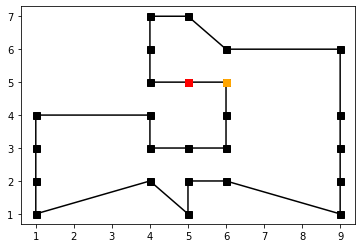

In [23]:
%%time
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/VoxTrebleBosster.txt'
df = pd.read_csv(url)
Y = df.values

X = buid_distance_matrix(Y)

aco, x, y = ant_colony_optimization(X, ants = 4, iterations = 50, alpha = 1, beta = 2, decay = 0.10)

plot_tour_coordinates(Y, aco)

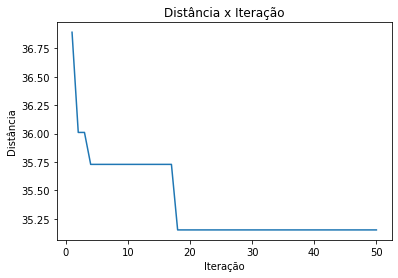

In [24]:
plt.plot(x,y)
plt.title('Distância x Iteração')
plt.xlabel("Iteração")
plt.ylabel("Distância")
plt.show()

# Instância 2 - Echoplex Preamp (31 pontos)

Iteration =  1  -> Distance =  43.34166020071207
Iteration =  2  -> Distance =  43.34166020071207
Iteration =  3  -> Distance =  41.74000583838024
Iteration =  4  -> Distance =  41.74000583838024
Iteration =  5  -> Distance =  40.957417329238154
Iteration =  6  -> Distance =  40.957417329238154
Iteration =  7  -> Distance =  40.957417329238154
Iteration =  8  -> Distance =  40.957417329238154
Iteration =  9  -> Distance =  40.06449510224598
Iteration =  10  -> Distance =  40.06449510224598
Iteration =  11  -> Distance =  40.06449510224598
Iteration =  12  -> Distance =  40.06449510224598
Iteration =  13  -> Distance =  40.06449510224598
Iteration =  14  -> Distance =  40.06449510224598
Iteration =  15  -> Distance =  40.06449510224598
Iteration =  16  -> Distance =  40.06449510224598
Iteration =  17  -> Distance =  40.06449510224598
Iteration =  18  -> Distance =  40.06449510224598
Iteration =  19  -> Distance =  40.06449510224598
Iteration =  20  -> Distance =  40.06449510224598
Itera

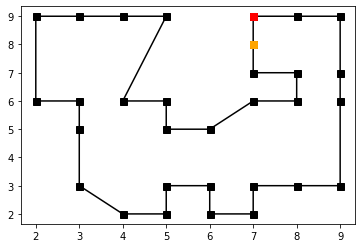

In [27]:
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/EchoplexPreamp.txt'
df = pd.read_csv(url)
Y = df.values

X = buid_distance_matrix(Y)

aco, x, y = ant_colony_optimization(X, ants = 4, iterations = 50, alpha = 1, beta = 2, decay = 0.10)

plot_tour_coordinates(Y, aco)

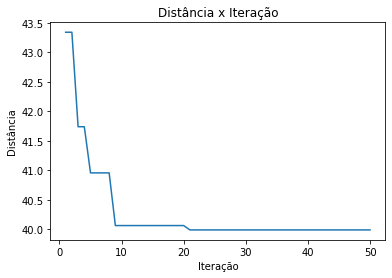

In [28]:
plt.plot(x,y)
plt.title('Distância x Iteração')
plt.xlabel("Iteração")
plt.ylabel("Distância")
plt.show()

# Instância 3 - RAT (70 pontos)

Iteration =  1  -> Distance =  92.57291002461345
Iteration =  2  -> Distance =  92.57291002461345
Iteration =  3  -> Distance =  92.42800518643799
Iteration =  4  -> Distance =  92.42800518643799
Iteration =  5  -> Distance =  92.42800518643799
Iteration =  6  -> Distance =  92.30120928457167
Iteration =  7  -> Distance =  92.30120928457167
Iteration =  8  -> Distance =  92.30120928457167
Iteration =  9  -> Distance =  87.53065784347338
Iteration =  10  -> Distance =  87.53065784347338
Iteration =  11  -> Distance =  87.53065784347338
Iteration =  12  -> Distance =  87.53065784347338
Iteration =  13  -> Distance =  87.53065784347338
Iteration =  14  -> Distance =  87.53065784347338
Iteration =  15  -> Distance =  87.53065784347338
Iteration =  16  -> Distance =  87.53065784347338
Iteration =  17  -> Distance =  87.53065784347338
Iteration =  18  -> Distance =  87.53065784347338
Iteration =  19  -> Distance =  87.53065784347338
Iteration =  20  -> Distance =  87.53065784347338
Iteration

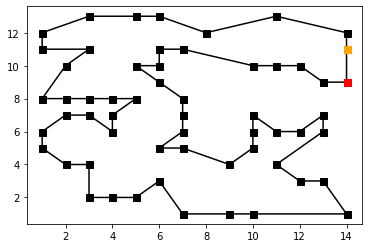

In [29]:
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/RAT.txt'
df = pd.read_csv(url)
Y = df.values

X = buid_distance_matrix(Y)

aco, x, y = ant_colony_optimization(X, ants = 4, iterations = 50, alpha = 1, beta = 2, decay = 0.10)

plot_tour_coordinates(Y, aco)

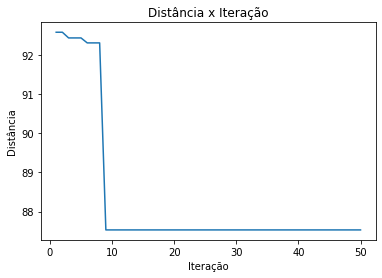

In [30]:
plt.plot(x,y)
plt.title('Distância x Iteração')
plt.xlabel("Iteração")
plt.ylabel("Distância")
plt.show()

# Instância 4 - OCD

Iteration =  1  -> Distance =  111.39642575646616
Iteration =  2  -> Distance =  111.39642575646616
Iteration =  3  -> Distance =  111.39642575646616
Iteration =  4  -> Distance =  107.47545795631281
Iteration =  5  -> Distance =  107.47545795631281
Iteration =  6  -> Distance =  107.47545795631281
Iteration =  7  -> Distance =  107.47545795631281
Iteration =  8  -> Distance =  107.47545795631281
Iteration =  9  -> Distance =  107.47545795631281
Iteration =  10  -> Distance =  107.47545795631281
Iteration =  11  -> Distance =  107.47545795631281
Iteration =  12  -> Distance =  107.47545795631281
Iteration =  13  -> Distance =  107.47545795631281
Iteration =  14  -> Distance =  107.47545795631281
Iteration =  15  -> Distance =  107.47545795631281
Iteration =  16  -> Distance =  107.47545795631281
Iteration =  17  -> Distance =  107.47545795631281
Iteration =  18  -> Distance =  107.47545795631281
Iteration =  19  -> Distance =  107.47545795631281
Iteration =  20  -> Distance =  107.4754

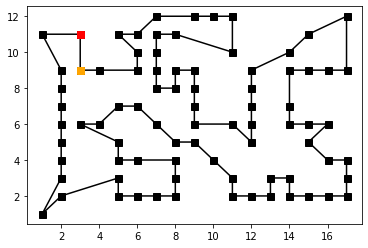

In [32]:
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/OCD.txt'
df = pd.read_csv(url)
Y = df.values

X = buid_distance_matrix(Y)

aco, x, y = ant_colony_optimization(X, ants = 4, iterations = 50, alpha = 1, beta = 2, decay = 0.10)

plot_tour_coordinates(Y, aco)

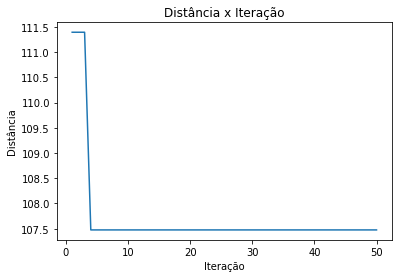

In [33]:
plt.plot(x,y)
plt.title('Distância x Iteração')
plt.xlabel("Iteração")
plt.ylabel("Distância")
plt.show()

# Instância 5 - Blues Driver (157 pontos)

Iteration =  1  -> Distance =  234.09694844948888
Iteration =  2  -> Distance =  234.09694844948888
Iteration =  3  -> Distance =  234.09694844948888
Iteration =  4  -> Distance =  228.94631131127153
Iteration =  5  -> Distance =  227.85397727274793
Iteration =  6  -> Distance =  227.85397727274793
Iteration =  7  -> Distance =  227.85397727274793
Iteration =  8  -> Distance =  227.4713018465661
Iteration =  9  -> Distance =  227.4713018465661
Iteration =  10  -> Distance =  227.4713018465661
Iteration =  11  -> Distance =  224.52804983152643
Iteration =  12  -> Distance =  224.52804983152643
Iteration =  13  -> Distance =  224.52804983152643
Iteration =  14  -> Distance =  224.52804983152643
Iteration =  15  -> Distance =  224.52804983152643
Iteration =  16  -> Distance =  223.95122684477067
Iteration =  17  -> Distance =  223.95122684477067
Iteration =  18  -> Distance =  223.95122684477067
Iteration =  19  -> Distance =  223.95122684477067
Iteration =  20  -> Distance =  223.9512268

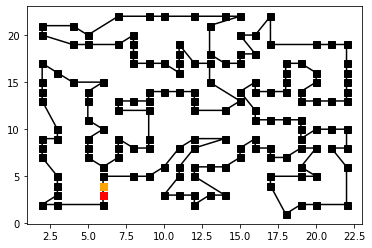

In [34]:
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/Blues%20driver.txt'
df = pd.read_csv(url)
Y = df.values

X = buid_distance_matrix(Y)

aco, x, y = ant_colony_optimization(X, ants = 4, iterations = 50, alpha = 1, beta = 2, decay = 0.10)

plot_tour_coordinates(Y, aco)

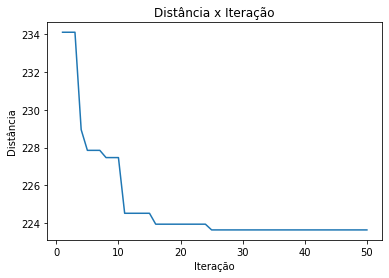

In [35]:
plt.plot(x,y)
plt.title('Distância x Iteração')
plt.xlabel("Iteração")
plt.ylabel("Distância")
plt.show()